In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import math
from utils import resize_image
import numpy as np
import glob

In [5]:
# Set of images with the root cropped out
foldername = 'testdata/'
imgs = glob.glob(foldername + '*.jpg')
img = imgs[0]
len(imgs)

6

In [6]:
## Helper functions
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_lines(imggray, thresh, opening=True):
    kernel_morph = np.ones((5,5),np.uint8)
    w, l = imggray.shape
    # Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    # Threshold
    ret,th1 = cv2.threshold(imggray,thresh,255,cv2.THRESH_BINARY)

    # Do some morphology opening by default
    if opening:
        morphOpening = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel_morph)
        lines = cv2.HoughLinesP(morphOpening, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    else:
        closing = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, kernel_morph)
        lines = cv2.HoughLinesP(closing, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
    if check_lines(lines, w):
        lines, th1, morphOpening = get_lines(imggray, thresh-10)
        
    return lines, th1, morphOpening

def draw_lines(image, rightlines, leftlines):
    """
    Given discovered lines using the HoughLines transform
    Extrapolate the lines, figure out where they
    intercept and return the extrapolated lines
    """
    w, l, _ = image.shape
    scalingfactor = 10
    rline = np.mean(rightlines, axis=0, dtype=int)[0]
    lline = np.mean(leftlines, axis=0, dtype=int)[0]
    p1 = np.array((lline[0],lline[1]))
    p2 = np.array((lline[2],lline[3]))
    p3 = np.array((rline[0], rline[1]))
    p4 = np.array((rline[2], rline[3]))
    x3,x4 = seg_intersect(p1, p2, p3, p4)
    
    x1_leftx, y1_leftx = lline[0], lline[1]
    gradl, interceptl = get_line_grad(x1_leftx, y1_leftx, x3, x4)
    
    x1_left = 1*w/scalingfactor
    y1_left = gradl * x1_left + interceptl
    leftl = [x1_left, y1_left, x3, x4]
    
    x1_rightx, y1_rightx = rline[0], rline[1]
    gradr, interceptr = get_line_grad(x1_rightx, y1_rightx, x3, x4)
    
    x1_right = (scalingfactor-2)*w/scalingfactor
    y1_right = gradr * x1_right + interceptr
    rightl = [x1_right, y1_right, x3, x4]
    
    x1_left,y1_left,x1_right,y1_right,x3,x4 = int(x1_left),int(y1_left),int(x1_right),int(y1_right),int(x3),int(x4)
    
    cv2.line(image, (int(x1_left), int(y1_left)), (int(x3), int(x4)), color=[255, 0, 0], thickness=6)
    cv2.line(image, (int(x1_right), int(y1_right)), (int(x3), int(x4)), color=[255, 0, 0], thickness=6)
    
    pts = [(x1_left, y1_left), (x3, x4), (x1_right, y1_right)]
    
    return image, pts

def get_line_grad(x1, y1, x2, y2):
    '''Get gradient of a line'''
    grad = (y2 - y1) / (x2 - x1)
    line_intercept = y1 - (grad * x1)
    return grad, line_intercept

def get_angles(pts):
    '''Get angle made by a polygon with lines from pt1-pt2-p3'''
    pt1, pt2, pt3 = pts
    ang1 = get_angle(pt2, pt3) * -1
    ang2 = 180 - get_angle(pt2, pt1)
    return ang1, ang2, ang2-ang1

def get_angle(pt1, pt2):
    '''Get angle between the horizontal and the line made form pt1-pt2'''
    x1, y1 = pt1
    x2, y2 = pt2
    return int(math.atan((y1-y2)/(x2-x1))*180/math.pi)

def annotate_image(img, points):
    '''Write the degree figure on the final image'''
    ang1, ang2, angle = get_angles(points[-3:])
    cv2.ellipse(img, points[-2], (30,30), 0, ang1, ang2, (200,255,255),2)
    ax, ay = points[-2]
    cv2.putText(img,str(angle)+ ' deg',(ax-30, ay+70),cv2.FONT_HERSHEY_SIMPLEX,0.7, (255,255,255), 2, cv2.LINE_AA)
    return img

def check_lines(lines,w):
    '''Check that we get a line or that the line is atleast a reasonable length'''    
    if lines is None: return True
    [x1,y1,x2,y2] = np.mean(lines, axis=0, dtype=int)[0]
    lengthline = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    if lengthline < w/10:
        return True
    return False

def weighted_img(img, initial_img, α=0.8, β=0.8, λ=0.):
    '''initial_img * α + img * β + λ'''
    return cv2.addWeighted(initial_img, α, img, β, λ)

def perp(a):
    '''No idea what this does :-)'''
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2):
    '''
    Based on https://stackoverflow.com/questions/3252194/numpy-and-line-intersections
    line segment a given by endpoints a1, a2
    line segment b given by endpoints b1, b2
    '''
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

## Run through single images

In [7]:
def calculate_angles(imgpath):
    ## define some parameters
    kernel_size = 9
    kernel_morph = np.ones((5,5),np.uint8)
    lower_threshold = 150 # Threshold for segmentation
    #------------------

    img = cv2.imread(imgpath)
    gray = grayscale(img)
    gray = gaussian_blur(gray, kernel_size)

    imgshape = gray.shape
    l = imgshape[1]
    w = imgshape[0]

    # Get region of interest
    leftvertices = np.array([[(l/10, w/3),(4*l/10, w/3), (4*l/10, 2*w/3), (l/10, 2*w/3)]], dtype=np.int32)
    rightvertices = np.array([[(6*l/10, w/3),(9*l/10, w/3), (9*l/10, 2*w/3), (6*l/10, 2*w/3)]], dtype=np.int32)
    roileft = region_of_interest(gray, leftvertices)
    roiright = region_of_interest(gray, rightvertices)

    # Get lines
    leftlines, thl, mo = get_lines(roileft, lower_threshold)
    rightlines, thr, mr = get_lines(roiright, lower_threshold)

    # Get final image
    img_zeros = np.zeros_like(img)
    imgx, pts = draw_lines(img_zeros, rightlines, leftlines)
    wimg = weighted_img(imgx, img)

    imgxx = annotate_image(wimg, pts)
    return imgxx

In [8]:
results = []
for img in imgs:
    imgoutputfname = img.split('/')[-1].split('.')[0]
    imgoutputfname = 'output/'+ imgoutputfname+'_result.jpg'
    imgresult = calculate_angles(img)
    imgresultrgb = cv2.cvtColor(imgresult, cv2.COLOR_BGR2RGB)
    results.append(imgresult)
    cv2.imwrite(imgoutputfname, imgresultrgb)

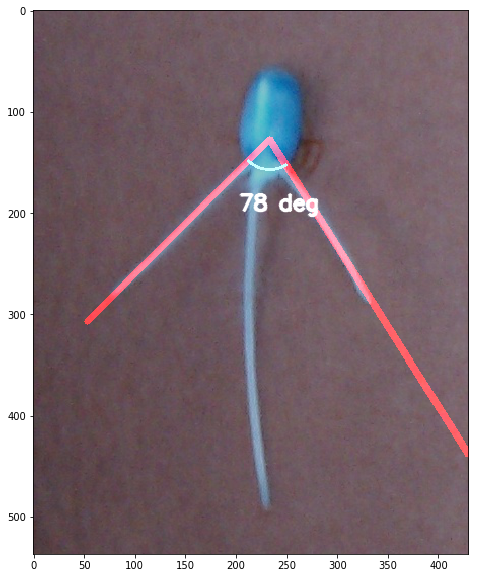

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(results[3])